## Evaluation

### General imports

In [1]:
import sys
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu, wilcoxon
sns.set(font_scale=1.4)
sns.set_style("white")

df = pd.read_csv("../data/results30.csv")

### Total number of projects

In [2]:
projects = df['project'].unique()
len(projects)

1000

### Size pareto front

21.466295506067475


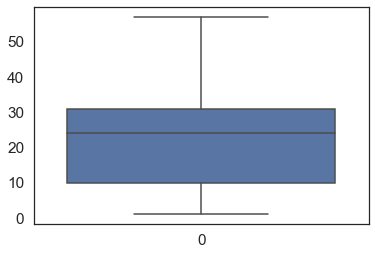

In [3]:
projects_with_seed = df[['project', 'seed']]
projects_with_seed_size = projects_with_seed.groupby(['project', 'seed']).size()
pareto_size = projects_with_seed_size.to_frame(name = 'size').reset_index()
pareto_size_plot = sns.boxplot(data = pareto_size['size'])
pareto_size_plot.get_figure().savefig("../pictures/evaluation/SizeParetoFront.pdf", bbox_inches="tight")
print(pareto_size['size'].mean())

### Mean Projects over all seeds

In [4]:
mean_projects_over_all_seeds = df.groupby(['project']).mean()

### Number of projects with no refactorings applied

In [87]:
# Warning: This takes a while
refactoring_names = ["conjunction_to_ifs", "conjunction_to_ifelse", "disjunction_to_ifelse", "extract_loop_condition", "extract_event_handler", "forever_if_to_wait_until",
                    "forever_wait_to_forever_if", "ifs_to_conjunction", "ififelse_to_conjunction", "ifelse_to_disjunction", "ifelse_to_ififnot", "ififnot_to_ifelse",
                    "inline_loop_condition", "loop_unrolling", "merge_double_if", "merge_event_handler", "merge_loops",
                    "merge_scripts", "merge_scripts_after_until", "sequence_to_loop", "split_if", "split_loop", "split_script",
                    "split_slice", "swap_statements", "split_script_after_until"]
non_refactored_projects_sum = 0
nfprojects = {}
for seed in range(0, 30):
    seed_df = df[df['seed'] == seed]
    projects_with_seed = seed_df[['project', 'seed']]
    projects_with_seed_size = projects_with_seed.groupby(['project', 'seed']).size()
    pareto_size = projects_with_seed_size.to_frame(name = 'size').reset_index()
    projects_with_one_solution = pareto_size[pareto_size['size'] == 1]
    data_frames_with_one_solution = []
    for index, row in projects_with_one_solution.iterrows():
        data_frames_with_one_solution.append(seed_df[seed_df['project'] == row['project']])
    number_non_refactored_projects = 0
    nfprojects_seed = []
    for data_frame in data_frames_with_one_solution:
        values = data_frame[refactoring_names].apply(sum, axis=1).values
        if values[0] == 0:            
            number_non_refactored_projects += 1
            nfprojects_seed.append(data_frame['project'].values[0])
            name = data_frame['project'].values[0]
            if name in nfprojects:
                nfprojects[name] += 1
            else:
                nfprojects[name] = 1

    non_refactored_projects_sum += number_non_refactored_projects
    print(f"seed: {seed}; number of non-refactored programs: {number_non_refactored_projects}")
print(f"average: {non_refactored_projects_sum / 30}")
nf = 0
for (project, value) in nfprojects.items():
    # Check if key is even then add pair to new dictionary
    print(f"Project {project}: {value}")
    if value != 30:
        nf +=1
print(f"\\newcommand{{\\projectsNotRefactored}}{{{nf}}}")
print(f"\\newcommand{{\\projectsRefactored}}{{{len(projects) - nf}}}")

seed: 0; number of non-refactored programs: 88
seed: 1; number of non-refactored programs: 86
seed: 2; number of non-refactored programs: 89
seed: 3; number of non-refactored programs: 86
seed: 4; number of non-refactored programs: 88
seed: 5; number of non-refactored programs: 98
seed: 6; number of non-refactored programs: 84
seed: 7; number of non-refactored programs: 85
seed: 8; number of non-refactored programs: 100
seed: 9; number of non-refactored programs: 84
seed: 10; number of non-refactored programs: 86
seed: 11; number of non-refactored programs: 83
seed: 12; number of non-refactored programs: 100
seed: 13; number of non-refactored programs: 99
seed: 14; number of non-refactored programs: 82
seed: 15; number of non-refactored programs: 95
seed: 16; number of non-refactored programs: 91
seed: 17; number of non-refactored programs: 98
seed: 18; number of non-refactored programs: 85
seed: 19; number of non-refactored programs: 85
seed: 20; number of non-refactored programs: 83


### Projects with refactoring that dominates original solution

In [88]:
dominated = df[df['dominated'] == 1]
dominated_projects = dominated['project'].unique()
print(f"\\newcommand{{\\projectsWithDominatingSolution}}{{{len(dominated_projects)}}}")

\newcommand{\projectsWithDominatingSolution}{354}


### Are non-dominated projects smaller projects?

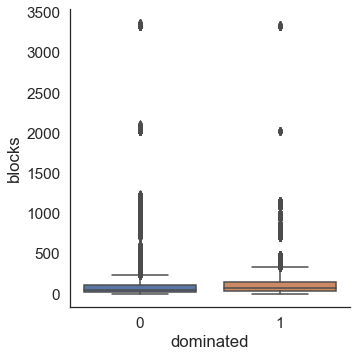

In [7]:
dominated_smaller_plot = sns.catplot(x="dominated", y="blocks", kind="box", data=df)
dominated_smaller_plot.savefig("../pictures/evaluation/NonDominatedSmaller.pdf", bbox_inches="tight")

In [8]:
project_dominated = []
project_non_dominated = []
for project in df['project'].unique():
  item = df[
    (df['project'] == project)
  ]

  mean_dominated = item[item['dominated'] == 1]['blocks'].mean()
  # TODO does this do what we want? 
  if math.isnan(mean_dominated):
    continue
  mean_non_dominated = item[item['dominated'] == 0]['blocks'].mean()
  # TODO does this do what we want? 
  if math.isnan(mean_non_dominated):
    continue
  project_dominated.append(mean_dominated)
  project_non_dominated.append(mean_non_dominated)
  # print(f"mean_dominated: {mean_dominated}")
  # print(f"mean_non_dominated: {mean_non_dominated}")
avg_dominated_blocks = sum(project_dominated) / len(project_dominated)
avg_non_dominated_blocks = sum(project_non_dominated) / len(project_non_dominated)
print(f"non-dominated average mean of blocks: {avg_non_dominated_blocks}")
print(f"dominated average mean of blocks: {avg_dominated_blocks}")

non-dominated average mean of blocks: 161.936034485778
dominated average mean of blocks: 155.01391007780444


In [9]:
# mannwhitneyu_blocks_dominated_sum = 0
# for seed in range(0, 30):
#     nondominated_blocks = df[(df['seed'] == seed) & (df['dominated'] == 0)].groupby('project')['blocks'].min().to_frame(name = 'Blocks')
#     dominated_blocks   = df[(df['seed'] == seed) & (df['dominated'] == 1)].groupby('project')['blocks'].min().to_frame(name = 'Blocks')
#     nondominated_blocks['Program'] = 'Nondominated'
#     dominated_blocks['Program'] = 'Dominated'
#     result = mannwhitneyu(nondominated_blocks['Blocks'], dominated_blocks['Blocks'])
#     mannwhitneyu_blocks_dominated_sum += result[1]
#     print(f"seed: {seed}; mannwhitneyu: {result[1]}")
# print(f"average: {mannwhitneyu_blocks_dominated_sum / 30}")

### Distribution of complexity improvements

In [10]:
complexities = []
original_complexities = []
for project in df['project'].unique():
  project_avg = []
  project_avg_original = []
  # TODO run with all 30 seeds (WARNING: takes around 20-30 minutes)
  for seed in range(0, 30):
    item = df[
      (df['project'] == project)
      & (df['seed'] == seed)
    ]
    minimum = item['average_complexity_fitness'].min()
    minimum_original = item['average_complexity_fitness_without_refactoring'].min()
    project_avg.append(minimum)
    project_avg_original.append(minimum_original)
  avg = sum(project_avg) / len(project_avg)
  avg_original = sum(project_avg_original) / len(project_avg_original)
  complexities.append(avg)
  original_complexities.append(avg_original)
refactored_complexities = {
    'Complexity': complexities
}
refactored_complexities_original = {
    'Complexity': original_complexities
}
refactored_complexities_df = pd.DataFrame(refactored_complexities, columns = ['Complexity'], index=projects)
refactored_complexities_df['Program'] = 'Refactored'
refactored_complexities_original_df = pd.DataFrame(refactored_complexities_original, columns = ['Complexity'], index=projects)
refactored_complexities_original_df['Program'] = 'Original'

both = pd.concat((refactored_complexities_original_df, refactored_complexities_df))
both

,Complexity,Program
400160883_24-05-2021_11-41-45,4.000000,Original
401035363_21-05-2021_07-33-10,3.000000,Original
400209164_25-05-2021_13-52-42,4.173864,Original
400063360_22-05-2021_02-15-40,2.400000,Original
400217464_25-05-2021_18-39-06,5.800000,Original
...,...,...
401054474_21-05-2021_22-50-00,1.183101,Refactored
401029944_21-05-2021_03-35-44,3.800000,Refactored
402002729_13-05-2021_15-56-02,3.902778,Refactored
400068771_22-05-2021_06-09-05,0.055556,Refactored


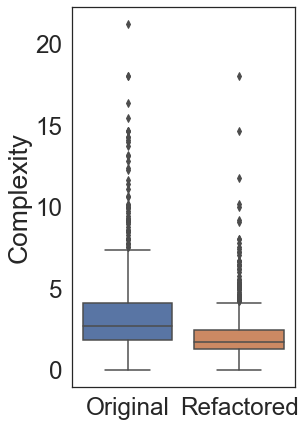

In [11]:
sns.set(rc={'figure.figsize':(4,7)})
sns.set_theme(style="white", font_scale=2.2)

complexity_plot = sns.boxplot(x = 'Program', y = 'Complexity', data=both)
complexity_plot.set(xlabel=None)
complexity_plot.get_figure().savefig("../pictures/evaluation/Complexity.pdf", bbox_inches="tight")

In [12]:
wc = wilcoxon(refactored_complexities_df['Complexity'], refactored_complexities_original_df['Complexity'])
if wc[1] < 0.001:
    print(f"\\newcommand{{\\complexityAfterRefactoringP}}{{< 0.001}}")
else:
    print(f"\\newcommand{{\\complexityAfterRefactoringP}}{{{wc[1]}}}")


\newcommand{\complexityAfterRefactoringP}{< 0.001}


In [91]:
print(f"\\newcommand{{\\meanComplexityBeforeRefactoring}}{{{refactored_complexities_original_df.mean()[0]}}}")
print(f"\\newcommand{{\\meanComplexityAfterRefactoring}}{{{refactored_complexities_df.mean()[0]}}}")

\newcommand{\meanComplexityBeforeRefactoring}{3.3636309183391457}
\newcommand{\meanComplexityAfterRefactoring}{2.08291137174689}


In [13]:
# mannwhitneyu_complexity_sum = 0
# for seed in range(0, 30):
#     refactored_complexities = df[df['seed'] == seed].groupby('project')['average_complexity_fitness'].min().to_frame(name = 'Complexity')
#     original_complexities   = df[df['seed'] == seed].groupby('project')['average_complexity_fitness_without_refactoring'].min().to_frame(name = 'Complexity')
#     refactored_complexities['Program'] = 'Refactored'
#     original_complexities['Program'] = 'Original'
#     result = mannwhitneyu(original_complexities['Complexity'], refactored_complexities['Complexity'])
#     mannwhitneyu_complexity_sum += result[1]
#     print(f"seed: {seed}; mannwhitneyu: {result[1]}")
# print(f"average: {mannwhitneyu_complexity_sum / 30}")

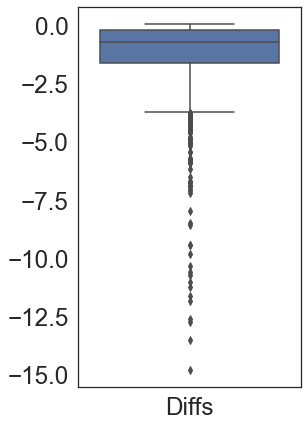

In [14]:
# diff = df.groupby('project')['average_complexity_fitness'].min().subtract(df.groupby('project')['average_complexity_fitness_without_refactoring'].min())
# complexity_diff_plot = sns.boxplot(data = diff)
# complexity_diff_plot.get_figure().savefig("../pictures/evaluation/ComplexityDiff.pdf", bbox_inches="tight")

diffs = []
for project in df['project'].unique():
  project_avg = []
  project_avg_original = []
  # TODO run with all 30 seeds (WARNING: takes around 20-30 minutes)
  for seed in range(0, 30):
    item = df[
      (df['project'] == project)
      & (df['seed'] == seed)
    ]
    minimum = item['average_complexity_fitness'].min()
    minimum_original = item['average_complexity_fitness_without_refactoring'].min()
    project_avg.append(minimum)
    project_avg_original.append(minimum_original)
  avg = sum(project_avg) / len(project_avg)
  avg_original = sum(project_avg_original) / len(project_avg_original)
  subtraction = avg - avg_original
  diffs.append(subtraction)
refactored_diffs = {
    'Diffs': diffs
}
diff = pd.DataFrame(refactored_diffs, index=projects)
complexity_diff_plot = sns.boxplot(data = diff)
complexity_diff_plot.get_figure().savefig("../pictures/evaluation/ComplexityDiff.pdf", bbox_inches="tight")

### Distribution of entropy improvements

In [15]:
entropies = []
original_entropies = []
for project in df['project'].unique():
  project_avg = []
  project_avg_original = []
  # TODO run with all 30 seeds (WARNING: takes around 20-30 minutes)
  for seed in range(0, 30):
    item = df[
      (df['project'] == project)
      & (df['seed'] == seed)
    ]
    minimum = item['average_entropy_fitness'].min()
    minimum_original = item['average_entropy_fitness_without_refactoring'].min()
    project_avg.append(minimum)
    project_avg_original.append(minimum_original)
  avg = sum(project_avg) / len(project_avg)
  avg_original = sum(project_avg_original) / len(project_avg_original)
  entropies.append(avg)
  original_entropies.append(avg_original)
refactored_entropies = {
    'Entropy': entropies
}
refactored_entropies_original = {
    'Entropy': original_entropies
}
refactored_entropies_df = pd.DataFrame(refactored_entropies, columns = ['Entropy'], index=projects)
refactored_entropies_df['Program'] = 'Refactored'
refactored_entropies_original_df = pd.DataFrame(refactored_entropies_original, columns = ['Entropy'], index=projects)
refactored_entropies_original_df['Program'] = 'Original'
both = pd.concat((refactored_entropies_original_df, refactored_entropies_df))
both

,Entropy,Program
400160883_24-05-2021_11-41-45,1.317668,Original
401035363_21-05-2021_07-33-10,1.360964,Original
400209164_25-05-2021_13-52-42,2.064840,Original
400063360_22-05-2021_02-15-40,0.721928,Original
400217464_25-05-2021_18-39-06,1.535658,Original
...,...,...
401054474_21-05-2021_22-50-00,1.013220,Refactored
401029944_21-05-2021_03-35-44,1.019248,Refactored
402002729_13-05-2021_15-56-02,1.246598,Refactored
400068771_22-05-2021_06-09-05,0.995194,Refactored


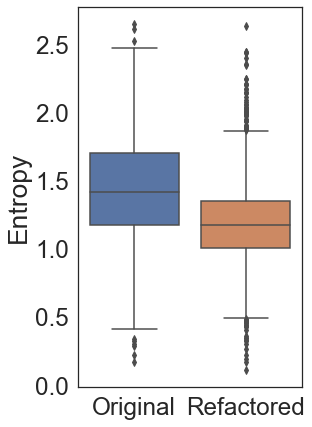

In [16]:
sns.set(rc={'figure.figsize':(4,7)})
sns.set_theme(style="white", font_scale=2.2)

entropy_plot = sns.boxplot(x = 'Program', y = 'Entropy', data=both)
entropy_plot.set(xlabel=None)
entropy_plot.get_figure().savefig("../pictures/evaluation/Entropy.pdf", bbox_inches="tight")

In [17]:
wc = wilcoxon(refactored_entropies_df['Entropy'], refactored_entropies_original_df['Entropy'])
if wc[1] < 0.001:
    print(f"\\newcommand{{\\entropyAfterRefactoringP}}{{< 0.001}}")
else:
    print(f"\\newcommand{{\\entropyAfterRefactoringP}}{{{wc[1]}}}")


\newcommand{\entropyAfterRefactoringP}{< 0.001}


In [90]:
print(f"\\newcommand{{\\meanEntropyBeforeRefactoring}}{{{refactored_entropies_original_df.mean()[0]}}}")
print(f"\\newcommand{{\\meanEntropyAfterRefactoring}}{{{refactored_entropies_df.mean()[0]}}}")

\newcommand{\meanEntropyBeforeRefactoring}{1.4447769417171383}
\newcommand{\meanEntropyAfterRefactoring}{1.1932980127859478}


In [18]:
# mannwhitneyu_entropy_sum = 0
# for seed in range(0, 30):
#     refactored_entropies = df[df['seed'] == seed].groupby('project')['average_entropy_fitness'].min().to_frame(name = 'Entropy')
#     original_entropies   = df[df['seed'] == seed].groupby('project')['average_entropy_fitness_without_refactoring'].min().to_frame(name = 'Entropy')
#     refactored_entropies['Program'] = 'Refactored'
#     original_entropies['Program'] = 'Original'
#     result = mannwhitneyu(original_entropies['Entropy'], refactored_entropies['Entropy'])
#     mannwhitneyu_entropy_sum += result[1]
#     print(f"seed: {seed}; mannwhitneyu: {result[1]}")
# print(f"average: {mannwhitneyu_entropy_sum / 30}")

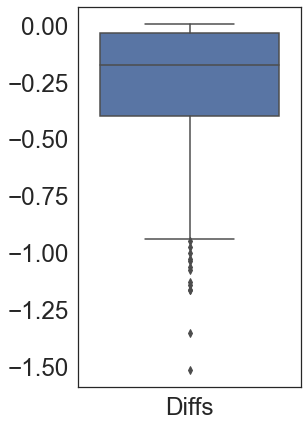

In [19]:
# diff = df.groupby('project')['average_entropy_fitness'].min().subtract(df.groupby('project')['average_entropy_fitness_without_refactoring'].min())
# entropy_diff_plot = sns.boxplot(data = diff)
# entropy_diff_plot.get_figure().savefig("../pictures/evaluation/EntropyDiff.pdf", bbox_inches="tight")

diffs = []
for project in df['project'].unique():
  project_avg = []
  project_avg_original = []
  # TODO run with all 30 seeds (WARNING: takes around 20-30 minutes)
  for seed in range(0, 30):
    item = df[
      (df['project'] == project)
      & (df['seed'] == seed)
    ]
    minimum = item['average_entropy_fitness'].min()
    minimum_original = item['average_entropy_fitness_without_refactoring'].min()
    project_avg.append(minimum)
    project_avg_original.append(minimum_original)
  avg = sum(project_avg) / len(project_avg)
  avg_original = sum(project_avg_original) / len(project_avg_original)
  subtraction = avg - avg_original
  diffs.append(subtraction)
refactored_diffs = {
    'Diffs': diffs
}
diff = pd.DataFrame(refactored_diffs, index=projects)
entropy_diff_plot = sns.boxplot(data = diff)
entropy_diff_plot.get_figure().savefig("../pictures/evaluation/EntropyDiff.pdf", bbox_inches="tight")

### Distribution of number of blocks improvements

In [20]:
blocks = []
original_blocks = []
for project in df['project'].unique():
  project_avg = []
  project_avg_original = []
  # TODO run with all 30 seeds (WARNING: takes around 20-30 minutes)
  for seed in range(0, 30):
    item = df[
      (df['project'] == project)
      & (df['seed'] == seed)
    ]
    minimum = item['blocks'].min()
    minimum_original = item['blocks_without_refactoring'].min()
    project_avg.append(minimum)
    project_avg_original.append(minimum_original)
  avg = sum(project_avg) / len(project_avg)
  avg_original = sum(project_avg_original) / len(project_avg_original)
  blocks.append(avg)
  original_blocks.append(avg_original)
refactored_blocks = {
    'Blocks': blocks
}
refactored_blocks_original = {
    'Blocks': original_blocks
}
refactored_blocks_df = pd.DataFrame(refactored_blocks, columns = ['Blocks'], index=projects)
refactored_blocks_df['Program'] = 'Refactored'
refactored_blocks_original_df = pd.DataFrame(refactored_blocks_original, columns = ['Blocks'], index=projects)
refactored_blocks_original_df['Program'] = 'Original'

both = pd.concat((refactored_blocks_original_df, refactored_blocks_df))
both

,Blocks,Program
400160883_24-05-2021_11-41-45,10.0,Original
401035363_21-05-2021_07-33-10,10.0,Original
400209164_25-05-2021_13-52-42,113.0,Original
400063360_22-05-2021_02-15-40,10.0,Original
400217464_25-05-2021_18-39-06,25.0,Original
...,...,...
401054474_21-05-2021_22-50-00,136.0,Refactored
401029944_21-05-2021_03-35-44,17.0,Refactored
402002729_13-05-2021_15-56-02,50.0,Refactored
400068771_22-05-2021_06-09-05,35.0,Refactored


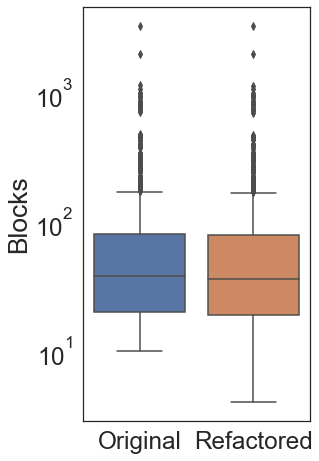

In [21]:
f, ax = plt.subplots(figsize=(5, 7))
ax.set_yscale("log")

#sns.set(rc={'figure.figsize':(5,7)})
sns.set_theme(style="white", font_scale=2.2)

block_plot = sns.boxplot(x = 'Program', y = 'Blocks', data=both, showfliers = True)
block_plot.set(xlabel=None)
block_figure= block_plot.get_figure()
block_figure.tight_layout()
block_figure.savefig("../pictures/evaluation/Blocks.pdf", bbox_inches="tight")

In [22]:
# mannwhitneyu_blocks_sum = 0
# for seed in range(0, 30):
#     refactored_blocks = df[df['seed'] == seed].groupby('project')['blocks'].min().to_frame(name = 'Blocks')
#     original_blocks   = df[df['seed'] == seed].groupby('project')['blocks_without_refactoring'].min().to_frame(name = 'Blocks')
#     refactored_blocks['Program'] = 'Refactored'
#     original_blocks['Program'] = 'Original'
#     result = mannwhitneyu(original_blocks['Blocks'], refactored_blocks['Blocks'])
#     mannwhitneyu_blocks_sum += result[1]
#     print(f"seed: {seed}; mannwhitneyu: {result[1]}")
# print(f"average: {mannwhitneyu_blocks_sum / 30}")

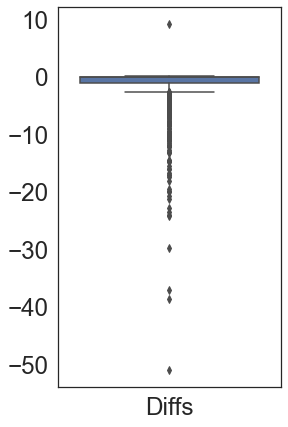

In [23]:
# diff = df.groupby('project')['blocks'].min().subtract(df.groupby('project')['blocks_without_refactoring'].min())
# block_diff_plot = sns.boxplot(data = diff)
# block_diff_plot.get_figure().savefig("../pictures/evaluation/BlocksDiff.pdf", bbox_inches="tight")

diffs = []
for project in df['project'].unique():
  project_avg = []
  project_avg_original = []
  # TODO run with all 30 seeds (WARNING: takes around 20-30 minutes)
  for seed in range(0, 30):
    item = df[
      (df['project'] == project)
      & (df['seed'] == seed)
    ]
    minimum = item['blocks'].min()
    minimum_original = item['blocks_without_refactoring'].min()
    project_avg.append(minimum)
    project_avg_original.append(minimum_original)
  avg = sum(project_avg) / len(project_avg)
  avg_original = sum(project_avg_original) / len(project_avg_original)
  subtraction = avg - avg_original
  diffs.append(subtraction)
refactored_diffs = {
    'Diffs': diffs
}
diff = pd.DataFrame(refactored_diffs, index=projects)
block_diff_plot = sns.boxplot(data = diff)
block_diff_plot.get_figure().savefig("../pictures/evaluation/BlocksDiff.pdf", bbox_inches="tight")

In [24]:
blocks_refactored = df.groupby('project')['blocks'].mean()
blocks_original   = df.groupby('project')['blocks_without_refactoring'].mean()

In [25]:
print(f"\\newcommand{{\\meanBlocksBeforeRefactoring}}{{{refactored_blocks_original_df.mean()[0]}}}")
print(f"\\newcommand{{\\meanBlocksAfterRefactoring}}{{{refactored_blocks_df.mean()[0]}}}")

\newcommand{\meanBlocksBeforeRefactoring}{86.27427427427428}
\newcommand{\meanBlocksAfterRefactoring}{84.53226559893226}


In [26]:
wc = wilcoxon(refactored_blocks_df['Blocks'], refactored_blocks_original_df['Blocks'])
if wc[1] < 0.001:
    print(f"\\newcommand{{\\blocksAfterRefactoringP}}{{< 0.001}}")
else:
    print(f"\\newcommand{{\\blocksAfterRefactoringP}}{{{wc[1]}}}")


\newcommand{\blocksAfterRefactoringP}{< 0.001}


In [27]:
dfp = df[df["blocks_without_refactoring"] < 10]
len(dfp["project"].unique())

0

<AxesSubplot:xlabel='blocks_without_refactoring', ylabel='Density'>

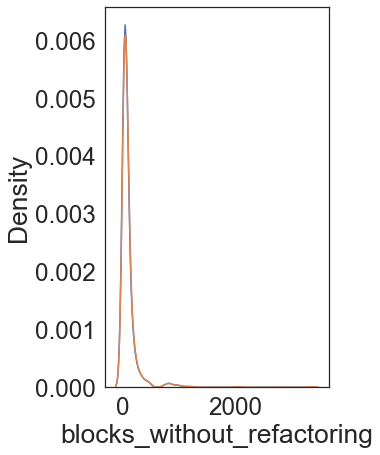

In [28]:
sns.kdeplot(blocks_original)
sns.kdeplot(blocks_refactored)

In [29]:
blocks_mean = []
original_blocks_mean = []
for project in df['project'].unique():
  project_avg = []
  project_avg_original = []
  # TODO run with all 30 seeds (WARNING: takes around 20-30 minutes)
  for seed in range(0, 30):
    item = df[
      (df['project'] == project)
      & (df['seed'] == seed)
    ]
    minimum = item['blocks'].mean()
    minimum_original = item['blocks_without_refactoring'].mean()
    project_avg.append(minimum)
    project_avg_original.append(minimum_original)
  avg = sum(project_avg) / len(project_avg)
  avg_original = sum(project_avg_original) / len(project_avg_original)
  blocks_mean.append(avg)
  original_blocks_mean.append(avg_original)
refactored_blocks_mean = {
    'Blocks': blocks_mean
}
refactored_blocks_original_mean = {
    'Blocks': original_blocks_mean
}
refactored_blocks_mean_df = pd.DataFrame(refactored_blocks_mean, columns = ['Blocks'], index=projects)
refactored_blocks_mean_df['Program'] = 'Refactored'
refactored_blocks_mean_original_df = pd.DataFrame(refactored_blocks_original_mean, columns = ['Blocks'], index=projects)
refactored_blocks_mean_original_df['Program'] = 'Original'

In [30]:
print(f"\\newcommand{{\\meanBlocksBeforeRefactoringMean}}{{{refactored_blocks_mean_original_df.mean()[0]}}}")
print(f"\\newcommand{{\\meanBlocksAfterRefactoringMean}}{{{refactored_blocks_mean_df.mean()[0]}}}")

\newcommand{\meanBlocksBeforeRefactoringMean}{86.27427427427428}
\newcommand{\meanBlocksAfterRefactoringMean}{89.2686217301114}


### Improvements per Objective

In [31]:
blocks = 'blocks'
blocks_without = 'blocks_without_refactoring'
complexity = 'average_complexity_fitness'
complexity_without = 'average_complexity_fitness_without_refactoring'
entropy = 'average_entropy_fitness'
entropy_without = 'average_entropy_fitness_without_refactoring'
projects = set(df['project'])


def a12(lst1,lst2,rev=True):
    "how often is x in lst1 more than y in lst2?"
    more = same = 0.0
    for x in lst1:
        for y in lst2:
            if x==y:
                same += 1
            elif rev and x > y:
                more += 1
            elif not rev and x < y:
                more += 1
    return (more + 0.5*same)/(len(lst1)*len(lst2))


def filter_data_frame(df, cols):
    return pd.DataFrame(df, columns=cols)


def get_combined_effect_size_wilcoxon(df, project, changed_col, unchanged_col):
    changed = filter_data_frame(df, ['project', changed_col])
    changed = changed[changed['project'] == project]
    unchanged = filter_data_frame(df, ['project', unchanged_col])
    unchanged = unchanged[unchanged['project'] == project]
    changed_data = changed[changed_col]
    unchanged_data = unchanged[unchanged_col]
    wilcoxon_test = wilcoxon(changed_data, unchanged_data, zero_method="zsplit")
    effect_size = a12(changed_data, unchanged_data)
    return effect_size, wilcoxon_test.pvalue



improved_results = {}
for project in projects:
    block_result = get_combined_effect_size_wilcoxon(
        df, project, blocks, blocks_without
    )
    complexity_result = get_combined_effect_size_wilcoxon(
        df, project, complexity, complexity_without
    )
    entropy_result = get_combined_effect_size_wilcoxon(
        df, project, entropy, entropy_without
    )
    improved_results[project] = {
        'blocksize': block_result,
        'complexity': complexity_result,
        'entropy': entropy_result,
    }


### Improved Single Objective

In [32]:
improved_blocks = 0
improved_complexity = 0
improved_entropy = 0
worse_blocks = 0
worse_complexity = 0
worse_entropy = 0
effect_sizes_blocks = []
effect_sizes_complexity = []
effect_sizes_entropy = []

for project in projects:
    improved_result = improved_results[project]
    block_result = improved_result['blocksize']
    complexity_result = improved_result['complexity']
    entropy_result = improved_result['entropy']
    
    if block_result[0] < 0.5 and block_result[1] < 0.05:
        improved_blocks += 1
    if block_result[0] > 0.5 and block_result[1] < 0.05:
        worse_blocks += 1
    if complexity_result[0] < 0.5 and complexity_result[1] < 0.05:
        improved_complexity += 1
    if complexity_result[0] > 0.5 and complexity_result[1] < 0.05:
        worse_complexity += 1
    if entropy_result[0] < 0.5 and entropy_result[1] < 0.05:
        improved_entropy += 1
    if entropy_result[0] > 0.5 and entropy_result[1] < 0.05:
        worse_entropy += 1
        
    effect_sizes_blocks.append(block_result[0])
    effect_sizes_complexity.append(complexity_result[0])
    effect_sizes_entropy.append(entropy_result[0])
        
print(f"Improved per block size: {improved_blocks}")  # 353
print(f"Improved per complexity: {improved_complexity}")  # 829
print(f"Improved per entropy:    {improved_entropy}")  # 832

print(f"Worse per block size: {worse_blocks}")
print(f"Worse per complexity: {worse_complexity}")
print(f"Worse per entropy:    {worse_entropy}")

print(f"Average A12 per block size: {sum(effect_sizes_blocks) / len(effect_sizes_blocks)}")
print(f"Average A12 per complexity: {sum(effect_sizes_complexity) / len(effect_sizes_complexity)}")
print(f"Average A12 per entropy: {sum(effect_sizes_entropy) / len(effect_sizes_entropy)}")

Improved per block size: 119
Improved per complexity: 765
Improved per entropy:    779
Worse per block size: 742
Worse per complexity: 94
Worse per entropy:    82
Average A12 per block size: 0.7325089133082981
Average A12 per complexity: 0.21632474540355612
Average A12 per entropy: 0.214709901512024


### Improved Pairwise Objectives

In [33]:
improved_blocks_complexity = 0
improved_blocks_entropy = 0
improved_complexity_entropy = 0
worse_blocks_complexity = 0
worse_blocks_entropy = 0
worse_complexity_entropy = 0
effect_sizes_blocks_complexity = 0.5 * (
    sum(effect_sizes_blocks) / len(effect_sizes_blocks)
    + sum(effect_sizes_complexity) / len(effect_sizes_complexity)
)
effect_sizes_blocks_entropy = 0.5 * (
    sum(effect_sizes_blocks) / len(effect_sizes_blocks)
    + sum(effect_sizes_entropy) / len(effect_sizes_entropy)
)
effect_sizes_complexity_entropy = 0.5 * (
    sum(effect_sizes_complexity) / len(effect_sizes_complexity)
    + sum(effect_sizes_entropy) / len(effect_sizes_entropy)
)

for project in projects:
    improved_result = improved_results[project]
    block_result = improved_result['blocksize']
    complexity_result = improved_result['complexity']
    entropy_result = improved_result['entropy']

    if (
            block_result[0] < 0.5 and block_result[1] < 0.05
            and complexity_result[0] < 0.5 and complexity_result[1] < 0.05
    ):
        improved_blocks_complexity += 1
    if (
            block_result[0] < 0.5 and block_result[1] < 0.05
            and entropy_result[0] < 0.5 and entropy_result[1] < 0.05
    ):
        improved_blocks_entropy += 1
    if (
            complexity_result[0] < 0.5 and complexity_result[1] < 0.05
            and entropy_result[0] < 0.5 and entropy_result[1] < 0.05
    ):
        improved_complexity_entropy += 1
        
    if (
        block_result[0] > 0.5 and block_result[1] < 0.05
        and complexity_result[0] > 0.5 and complexity_result[1] < 0.05
    ):
        worse_blocks_complexity += 1
    if (
        block_result[0] > 0.5 and block_result[1] < 0.05
        and entropy_result[0] > 0.5 and entropy_result[1] < 0.05
    ):
        worse_blocks_entropy += 1
    if (
        complexity_result[0] > 0.5 and complexity_result[1] < 0.05
        and entropy_result[0] > 0.5 and entropy_result[1] < 0.05
    ):
        worse_complexity_entropy += 1


print(f"Improved per block size and complexity: {improved_blocks_complexity}")  # 356
print(f"Improved per block size and entropy:    {improved_blocks_entropy}")  # 357
print(f"Improved per complexity and entropy:    {improved_complexity_entropy}")  # 799

print(f"Worse per block size and complexity: {worse_blocks_complexity}")
print(f"Worse per block size and entropy:    {worse_blocks_entropy}")
print(f"Worse per complexity and entropy:    {worse_complexity_entropy}")

print(f"Average A12 per block size and complexity: {effect_sizes_blocks_complexity}")
print(f"Average A12 per block size and entropy:    {effect_sizes_blocks_entropy}")
print(f"Average A12 per complexity and entropy:    {effect_sizes_complexity_entropy}")

Improved per block size and complexity: 88
Improved per block size and entropy:    86
Improved per complexity and entropy:    704
Worse per block size and complexity: 63
Worse per block size and entropy:    49
Worse per complexity and entropy:    21
Average A12 per block size and complexity: 0.4744168293559271
Average A12 per block size and entropy:    0.47360940741016105
Average A12 per complexity and entropy:    0.21551732345779007


### Improved over all three Objectives

In [34]:
improved_objectives = 0
worse_objectives = 0
effect_sizes_objectives = 1 / 3 * (
    sum(effect_sizes_blocks) / len(effect_sizes_blocks)
    + sum(effect_sizes_complexity) / len(effect_sizes_complexity)
    + sum(effect_sizes_entropy) / len(effect_sizes_entropy)
)
for project in projects:
    improved_result = improved_results[project]
    block_result = improved_result['blocksize']
    complexity_result = improved_result['complexity']
    entropy_result = improved_result['entropy']

    if (
            block_result[0] < 0.5 and block_result[1] < 0.05
            and complexity_result[0] < 0.5 and complexity_result[1] < 0.05
            and entropy_result[0] < 0.5 and entropy_result[1] < 0.05
    ):
        improved_objectives += 1
    if (
            block_result[0] > 0.5 and block_result[1] < 0.05
            and complexity_result[0] > 0.5 and complexity_result[1] < 0.05
            and entropy_result[0] > 0.5 and entropy_result[1] < 0.05
    ):
        worse_objectives += 1
print(f"Improved per all three objectives: {improved_objectives}")  # 349
print(f"Worse per all three objectives: {worse_objectives}")
print(f"Average A12 per all three objectives: {effect_sizes_objectives}")

Improved per all three objectives: 74
Worse per all three objectives: 2
Average A12 per all three objectives: 0.38784785340795935


### LaTeX Macros for Improvements

In [35]:
print("% Improved Single Objective")
print(f"\\newcommand{{\\blocksImproved}}{{{improved_blocks}}}")
print(f"\\newcommand{{\\complexityImproved}}{{{improved_complexity}}}")
print(f"\\newcommand{{\\entropyImproved}}{{{improved_entropy}}}")
print(f"\\newcommand{{\\blocksWorsened}}{{{worse_blocks}}}")
print(f"\\newcommand{{\\complexityWorsened}}{{{worse_complexity}}}")
print(f"\\newcommand{{\\entropyWorsened}}{{{worse_entropy}}}")
print(f"\\newcommand{{\\blocksAvgEffect}}{{{sum(effect_sizes_blocks) / len(effect_sizes_blocks)}}}")
print(f"\\newcommand{{\\complexityAvgEffect}}{{{sum(effect_sizes_complexity) / len(effect_sizes_complexity)}}}")
print(f"\\newcommand{{\\entropyAvgEffect}}{{{sum(effect_sizes_entropy) / len(effect_sizes_entropy)}}}")

print("% Improved Pairwise Objectives")
print(f"\\newcommand{{\\blocksComplexityImproved}}{{{improved_blocks_complexity}}}")
print(f"\\newcommand{{\\blocksEntropyImproved}}{{{improved_blocks_entropy}}}")
print(f"\\newcommand{{\\complexityEntropyImproved}}{{{improved_complexity_entropy}}}")
print(f"\\newcommand{{\\blocksComplexityWorsened}}{{{worse_blocks_complexity}}}")
print(f"\\newcommand{{\\blocksEntropyWorsened}}{{{worse_blocks_entropy}}}")
print(f"\\newcommand{{\\complexityEntropyWorsened}}{{{worse_complexity_entropy}}}")
print(f"\\newcommand{{\\blocksComplexityAvgEffect}}{{{effect_sizes_blocks_complexity}}}")
print(f"\\newcommand{{\\blocksEntropyAvgEffect}}{{{effect_sizes_blocks_entropy}}}")
print(f"\\newcommand{{\\complexityEntropyAvgEffect}}{{{effect_sizes_complexity_entropy}}}")

print("% Improved over all three Objectives")
print(f"\\newcommand{{\\dominatingSolutions}}{{{improved_objectives}}}")
print(f"\\newcommand{{\\threeObjectivesImproved}}{{{improved_objectives}}}")
print(f"\\newcommand{{\\threeObjectivesWorsened}}{{{worse_objectives}}}")
print(f"\\newcommand{{\\threeObjectivesAvgEffect}}{{{effect_sizes_objectives}}}")

% Improved Single Objective
\newcommand{\blocksImproved}{119}
\newcommand{\complexityImproved}{765}
\newcommand{\entropyImproved}{779}
\newcommand{\blocksWorsened}{742}
\newcommand{\complexityWorsened}{94}
\newcommand{\entropyWorsened}{82}
\newcommand{\blocksAvgEffect}{0.7325089133082981}
\newcommand{\complexityAvgEffect}{0.21632474540355612}
\newcommand{\entropyAvgEffect}{0.214709901512024}
% Improved Pairwise Objectives
\newcommand{\blocksComplexityImproved}{88}
\newcommand{\blocksEntropyImproved}{86}
\newcommand{\complexityEntropyImproved}{704}
\newcommand{\blocksComplexityWorsened}{63}
\newcommand{\blocksEntropyWorsened}{49}
\newcommand{\complexityEntropyWorsened}{21}
\newcommand{\blocksComplexityAvgEffect}{0.4744168293559271}
\newcommand{\blocksEntropyAvgEffect}{0.47360940741016105}
\newcommand{\complexityEntropyAvgEffect}{0.21551732345779007}
% Improved over all three Objectives
\newcommand{\dominatingSolutions}{74}
\newcommand{\threeObjectivesImproved}{74}
\newcommand{\threeObje

### Scripts

In [36]:
scripts = []
original_scripts = []
for project in df['project'].unique():
  project_avg = []
  project_avg_original = []
  for seed in range(0, 30):
    item = df[
      (df['project'] == project)
      & (df['seed'] == seed)
    ]
    minimum = item['scripts'].min()
    minimum_original = item['scripts_without_refactoring'].min()
    project_avg.append(minimum)
    project_avg_original.append(minimum_original)
  avg = sum(project_avg) / len(project_avg)
  avg_original = sum(project_avg_original) / len(project_avg_original)
  scripts.append(avg)
  original_scripts.append(avg_original)
refactored_scripts = {
    'Scripts': scripts
}
refactored_scripts_original = {
    'Scripts': original_scripts
}
refactored_scripts_df = pd.DataFrame(refactored_scripts, columns = ['Scripts'], index=projects)
refactored_scripts_df['Program'] = 'Refactored'
refactored_scripts_original_df = pd.DataFrame(refactored_scripts_original, columns = ['Scripts'], index=projects)
refactored_scripts_original_df['Program'] = 'Original'

both = pd.concat((refactored_scripts_original_df, refactored_scripts_df))
both

,Scripts,Program
401078299_22-05-2021_16-00-53,1.000000,Original
402115237_25-05-2021_09-52-01,1.000000,Original
402005109_13-05-2021_17-21-16,12.000000,Original
400102403_23-05-2021_02-26-45,2.000000,Original
401043546_21-05-2021_13-25-27,2.000000,Original
...,...,...
402172133_28-05-2021_14-12-17,35.000000,Refactored
402114879_25-05-2021_09-30-39,1.000000,Refactored
401015599_14-05-2021_01-41-13,2.000000,Refactored
400070584_22-05-2021_07-25-48,17.000000,Refactored


In [37]:
wc = wilcoxon(refactored_scripts_df['Scripts'], refactored_scripts_original_df['Scripts'], zero_method="zsplit")
if wc[1] < 0.001:
    print(f"\\newcommand{{\\scriptsP}}{{< 0.001}}")
else:
    print(f"\\newcommand{{\\scriptsP}}{{{wc[1]}}}")

\newcommand{\scriptsP}{< 0.001}


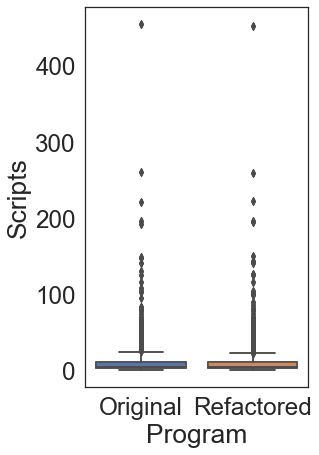

In [38]:
sns.boxplot(x = 'Program', y = 'Scripts', data=both)
scripts_plot = sns.boxplot(x = 'Program', y = 'Scripts', data=both)
scripts_plot.get_figure().savefig("../pictures/evaluation/Scripts.pdf", bbox_inches="tight")

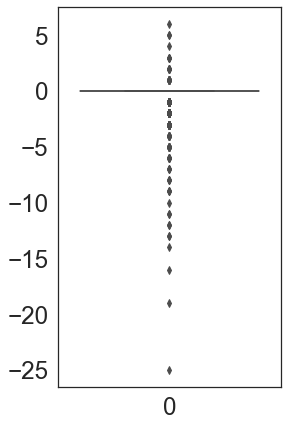

In [39]:
diff = df.groupby('project')['scripts'].min().subtract(df.groupby('project')['scripts_without_refactoring'].min()).to_frame(name = 'Scripts')
scripts_diff_plot = sns.boxplot(data = diff['Scripts'])
scripts_diff_plot.get_figure().savefig("../pictures/evaluation/ScriptsDiff.pdf", bbox_inches="tight")


#### Average mean of scripts in refactored and non-refactored projects

In [40]:
project_avg = []
project_avg_original = []
for project in df['project'].unique():
  item = df[
    (df['project'] == project)
  ]
  mean = item['scripts'].mean()
  mean_original = item['scripts_without_refactoring'].mean()
  project_avg.append(mean)
  project_avg_original.append(mean_original)
avg = sum(project_avg) / len(project_avg)
avg_original = sum(project_avg_original) / len(project_avg_original)
print(f"without refactoring average mean of scripts: {avg_original}")
print(f"with refactoring average mean of scripts: {avg}")
print(f"difference between average means of scripts: {avg - avg_original}")

without refactoring average mean of scripts: 12.404
with refactoring average mean of scripts: 14.696706477151562
difference between average means of scripts: 2.2927064771515617


In [41]:
# mannwhitneyu_scripts_sum = 0
# for seed in range(0, 30):
#     refactored_scripts = df[df['seed'] == seed].groupby('project')['scripts'].min().to_frame(name = 'Scripts')
#     original_scripts   = df[df['seed'] == seed].groupby('project')['scripts_without_refactoring'].min().to_frame(name = 'Scripts')
#     refactored_scripts['Program'] = 'Refactored'
#     original_scripts['Program'] = 'Original'
#     result = mannwhitneyu(original_scripts['Scripts'], refactored_scripts['Scripts'])
#     mannwhitneyu_scripts_sum += result[1]
#     print(f"seed: {seed}; mannwhitneyu: {result[1]}")
# print(f"average: {mannwhitneyu_scripts_sum / 30}")

### Long Script Smells

In [42]:
long_scripts = []
original_long_scripts = []
for project in df['project'].unique():
  project_avg = []
  project_avg_original = []
  # TODO run with all 30 seeds (WARNING: takes around 20-30 minutes)
  for seed in range(0, 30):
    item = df[
      (df['project'] == project)
      & (df['seed'] == seed)
    ]
    minimum = item['long_scripts'].min()
    minimum_original = item['long_scripts_without_refactoring'].min()
    project_avg.append(minimum)
    project_avg_original.append(minimum_original)
  avg = sum(project_avg) / len(project_avg)
  avg_original = sum(project_avg_original) / len(project_avg_original)
  long_scripts.append(avg)
  original_long_scripts.append(avg_original)
refactored_long_scripts = {
    'Long Scripts': long_scripts
}
refactored_long_scripts_original = {
    'Long Scripts': original_long_scripts
}
refactored_long_scripts_df = pd.DataFrame(refactored_long_scripts, columns = ['Long Scripts'], index=projects)
refactored_long_scripts_df['Program'] = 'Refactored'
refactored_long_scripts_original_df = pd.DataFrame(refactored_long_scripts_original, columns = ['Long Scripts'], index=projects)
refactored_long_scripts_original_df['Program'] = 'Original'

both = pd.concat((refactored_long_scripts_original_df, refactored_long_scripts_df))
both

,Long Scripts,Program
401078299_22-05-2021_16-00-53,0.0,Original
402115237_25-05-2021_09-52-01,0.0,Original
402005109_13-05-2021_17-21-16,4.0,Original
400102403_23-05-2021_02-26-45,0.0,Original
401043546_21-05-2021_13-25-27,1.0,Original
...,...,...
402172133_28-05-2021_14-12-17,2.0,Refactored
402114879_25-05-2021_09-30-39,1.0,Refactored
401015599_14-05-2021_01-41-13,2.0,Refactored
400070584_22-05-2021_07-25-48,0.0,Refactored


In [43]:
print(f"\\newcommand{{\\longscriptsAfterRefactoring}}{{{refactored_long_scripts_df.sum()[0]}}}")

\newcommand{\longscriptsAfterRefactoring}{694.8333333333333}


In [44]:
print(f"\\newcommand{{\\longscriptsBeforeRefactoring}}{{{refactored_long_scripts_original_df.sum()[0]}}}")

\newcommand{\longscriptsBeforeRefactoring}{860.0}


In [45]:
print(f"\\newcommand{{\\longscriptsDiff}}{{{refactored_long_scripts_original_df.sum()[0] - refactored_long_scripts_df.sum()[0]}}}")

\newcommand{\longscriptsDiff}{165.16666666666674}


In [46]:
wc = wilcoxon(refactored_long_scripts_df['Long Scripts'], refactored_long_scripts_original_df['Long Scripts'], zero_method="zsplit")
if wc[1] < 0.001:
    print(f"\\newcommand{{\\longscriptsP}}{{< 0.001}}")
else:
    print(f"\\newcommand{{\\longscriptsP}}{{{wc[1]}}}")

\newcommand{\longscriptsP}{< 0.001}


#### Mean of long scripts of refactored and non-refactored solutions

In [47]:
project_avg = []
project_avg_original = []
for project in df['project'].unique():
  item = df[
    (df['project'] == project)
  ]
  mean = item['long_scripts'].mean()
  mean_original = item['long_scripts_without_refactoring'].mean()
  project_avg.append(mean)
  project_avg_original.append(mean_original)
avg = sum(project_avg) / len(project_avg)
avg_original = sum(project_avg_original) / len(project_avg_original)
print(f"without refactoring average mean of long_scripts: {avg_original}")
print(f"with refactoring average mean of long_scripts: {avg}")
print(f"difference between average means of long_scripts: {avg_original - avg}")
print(f"percentage : {avg_original - avg}")

without refactoring average mean of long_scripts: 0.877
with refactoring average mean of long_scripts: 0.839206115638659
difference between average means of long_scripts: 0.03779388436134101
percentage : 0.03779388436134101


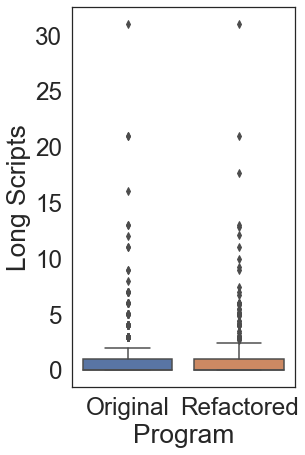

In [48]:
long_scripts_plot = sns.boxplot(x = 'Program', y = 'Long Scripts', data=both)
long_scripts_plot.get_figure().savefig("../pictures/evaluation/LongScripts.pdf", bbox_inches="tight")

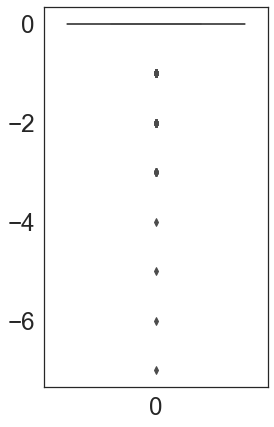

In [49]:
diff = df.groupby('project')['long_scripts'].min().subtract(df.groupby('project')['long_scripts_without_refactoring'].min())
long_scripts_diff_plot = sns.boxplot(data = diff)
long_scripts_diff_plot.get_figure().savefig("../pictures/evaluation/LongScriptsDiff.pdf", bbox_inches="tight")

In [50]:
# mannwhitneyu_long_scripts_sum = 0
# for seed in range(0, 30):
#     refactored_long_scripts = df[df['seed'] == seed].groupby('project')['long_scripts'].min().to_frame(name = 'Long Scripts')
#     original_long_scripts   = df[df['seed'] == seed].groupby('project')['long_scripts_without_refactoring'].min().to_frame(name = 'Long Scripts')
#     refactored_long_scripts['Program'] = 'Refactored'
#     original_long_scripts['Program'] = 'Original'
#     result = mannwhitneyu(original_long_scripts['Long Scripts'], refactored_long_scripts['Long Scripts'])
#     mannwhitneyu_long_scripts_sum += result[1]
#     print(f"seed: {seed}; mannwhitneyu: {result[1]}")
# print(f"average: {mannwhitneyu_long_scripts_sum / 30}")

In [51]:
# sum(original_smells['Long Scripts'])

In [52]:
# sum(refactored_smells['Long Scripts'])

### Mean of refactorings applied

In [53]:
refactoring_names = ["conjunction_to_ifs", "conjunction_to_ifelse", "disjunction_to_ifelse", "extract_loop_condition", "extract_event_handler", "forever_if_to_wait_until",
                    "forever_wait_to_forever_if", "ifs_to_conjunction", "ififelse_to_conjunction", "ifelse_to_disjunction", "ifelse_to_ififnot", "ififnot_to_ifelse",
                    "inline_loop_condition", "loop_unrolling", "merge_double_if", "merge_event_handler", "merge_loops",
                    "merge_scripts", "merge_scripts_after_until", "sequence_to_loop", "split_if", "split_loop", "split_script",
                    "split_slice", "swap_statements", "split_script_after_until"]

executed_refactorings_mean_sum = 0
project_avg = []
project_avg_original = []
for project in df['project'].unique():
  item = df[
    (df['project'] == project)
  ]
  executed_refactorings = item[refactoring_names].apply(sum, axis=1)
  executed_refactorings_mean = executed_refactorings.mean()
  project_avg.append(executed_refactorings_mean)
avg_refactorings = sum(project_avg) / len(project_avg)
print(f"mean refactorings applied over all projects: {avg_refactorings}")

mean refactorings applied over all projects: 10.074041192566897


### Number of refactorings applied

conjunction to ifelse:  0.04861297848768335
if if not to if else:  0.04948576778512537
if if not to if else (count):  3572
if if else to conjunction:  0.04948576778512537
extract independent subscripts:  16.357041199949517
split script:  16.473454667670236
merge scripts:  16.757055774145403
swap statements:  25.95603330841035


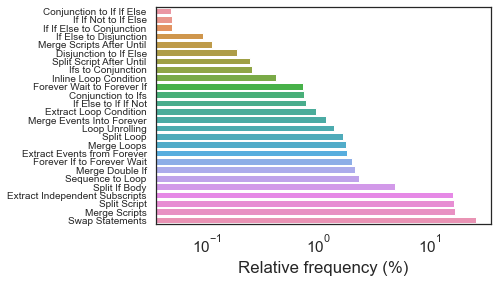

In [54]:
conjunction_to_ifs = sum(list(map(int, df.conjunction_to_ifs.to_list())))
conjunction_to_ifelse = sum(list(map(int, df.conjunction_to_ifelse.to_list())))
disjunction_to_ifelse = sum(list(map(int, df.disjunction_to_ifelse.to_list())))
extract_loop_condition = sum(list(map(int, df.extract_loop_condition.to_list())))
extract_event_handler = sum(list(map(int, df.extract_event_handler.to_list())))
forever_if_to_wait_until = sum(list(map(int, df.forever_if_to_wait_until.to_list())))
forever_wait_to_forever_if = sum(list(map(int, df.forever_wait_to_forever_if.to_list())))
ifs_to_conjunction = sum(list(map(int, df.ifs_to_conjunction.to_list())))
ififelse_to_conjunction = sum(list(map(int, df.ififelse_to_conjunction.to_list())))
ifelse_to_disjunction = sum(list(map(int, df.ifelse_to_disjunction.to_list())))
ifelse_to_ififnot = sum(list(map(int, df.ifelse_to_ififnot.to_list())))
ififnot_to_ifelse = sum(list(map(int, df.ififelse_to_conjunction.to_list())))
inline_loop_condition = sum(list(map(int, df.inline_loop_condition.to_list())))
loop_unrolling = sum(list(map(int, df.loop_unrolling.to_list())))
merge_double_if = sum(list(map(int, df.merge_double_if.to_list())))
merge_event_handler = sum(list(map(int, df.merge_event_handler.to_list())))
merge_loops = sum(list(map(int, df.merge_loops.to_list())))
merge_scripts = sum(list(map(int, df.merge_scripts.to_list())))
merge_scripts_after_until = sum(list(map(int, df.merge_scripts_after_until.to_list())))
sequence_to_loop = sum(list(map(int, df.sequence_to_loop.to_list())))
split_if = sum(list(map(int, df.split_if.to_list())))
split_loop = sum(list(map(int, df.split_loop.to_list())))
split_script = sum(list(map(int, df.split_script.to_list())))
split_slice = sum(list(map(int, df.split_slice.to_list())))
swap_statements = sum(list(map(int, df.swap_statements.to_list())))
split_script_after_until = sum(list(map(int, df.split_script_after_until.to_list())))
refactoring_values_absolute = [conjunction_to_ifs, conjunction_to_ifelse, disjunction_to_ifelse, extract_loop_condition, extract_event_handler, forever_if_to_wait_until,
                     forever_wait_to_forever_if, ifs_to_conjunction, ififelse_to_conjunction, ifelse_to_disjunction, ifelse_to_ififnot, ififnot_to_ifelse,
                     inline_loop_condition, loop_unrolling, merge_double_if, merge_event_handler, merge_loops, merge_scripts,
                     merge_scripts_after_until, sequence_to_loop, split_if, split_loop, split_script, split_slice, swap_statements, split_script_after_until]
executed_refactorings = df[refactoring_names].apply(sum, axis=1)
sum_executed_refactorings = sum(executed_refactorings)
refactoring_values = map(lambda x : (x * 100) / sum_executed_refactorings, refactoring_values_absolute)
refactoring_labels = ["Conjunction to Ifs", "Conjunction to If If Else", "Disjunction to If Else", "Extract Loop Condition", "Extract Events from Forever", "Forever If to Forever Wait",
                    "Forever Wait to Forever If", "Ifs to Conjunction", "If If Else to Conjunction", "If Else to Disjunction", "If Else to If If Not", "If If Not to If Else",
                    "Inline Loop Condition", "Loop Unrolling", "Merge Double If", "Merge Events Into Forever", "Merge Loops",
                    "Merge Scripts", "Merge Scripts After Until", "Sequence to Loop", "Split If Body", "Split Loop", "Split Script",
                    "Extract Independent Subscripts", "Swap Statements", "Split Script After Until"]
refactoring_data = pd.DataFrame(list(zip(refactoring_values, refactoring_labels)), columns =['value', 'transformation'])

sns.set(rc={'figure.figsize':(6,4)})
sns.set_theme(style="white", font_scale=1.4)

refactorings_applied_plot = sns.barplot(data = refactoring_data, x = "value", y = "transformation", order=refactoring_data.sort_values('value').transformation, log=True)
refactorings_applied_plot.set(xlabel='Relative frequency (%)', ylabel=None)
# todo remove the downscaling of the fontsize=11 as soon as we can increase the space between the bars
refactorings_applied_plot.set_yticklabels(refactorings_applied_plot.get_yticklabels(), fontsize=10)

#def change_height(ax, new_value) :
#    for patch in ax.patches:
#        current_height = patch.get_height()
#        diff = current_height - new_value
#        patch.set_height(new_value)
#        patch.set_y(patch.get_y() + diff * 0.5)
# change_height(refactorings_applied_plot, 2) # todo only makes bars higher but does not create space between them

#def change_width(ax, new_value) :
#    for patch in ax.patches:
#        current_width = patch.get_width()
#        diff = current_width - new_value
#        patch.set_width(new_value)
#        patch.set_x(patch.get_x() + diff * 0.5)
#change_width(refactorings_applied_plot, 2) # todo only makes bars wider but does not create space between them


print("conjunction to ifelse: ", (conjunction_to_ifelse * 100)/sum_executed_refactorings)
print("if if not to if else: ", (ififnot_to_ifelse * 100)/sum_executed_refactorings)
print("if if not to if else (count): ", ififnot_to_ifelse)
print("if if else to conjunction: ", (ififelse_to_conjunction * 100)/sum_executed_refactorings)
print("extract independent subscripts: ", (split_slice * 100)/sum_executed_refactorings)
print("split script: ", (split_script * 100)/sum_executed_refactorings)
print("merge scripts: ", (merge_scripts * 100)/sum_executed_refactorings)
print("swap statements: ", (swap_statements * 100)/sum_executed_refactorings)

refactorings_applied_plot.get_figure().savefig("../pictures/evaluation/TransformationsApplied.pdf", bbox_inches="tight")

In [55]:
print(f"\\newcommand{{\\transformationsmean}}{{{avg_refactorings}}}")
print(f"\\newcommand{{\\transformationscount}}{{{sum_executed_refactorings}}}")
print(f"\\newcommand{{\\swapcount}}{{{swap_statements}\\xspace}}")
print(f"\\newcommand{{\\swappercent}}{{\\SI{{{(swap_statements * 100)/sum_executed_refactorings}}}{{\\percent}}\\xspace}}")

print(f"\\newcommand{{\\mergescriptscount}}{{{merge_scripts}\\xspace}}")
print(f"\\newcommand{{\\mergescriptspercent}}{{\\SI{{{(merge_scripts * 100)/sum_executed_refactorings}}}{{\\percent}}\\xspace}}")

print(f"\\newcommand{{\\splitslicecount}}{{{split_slice}\\xspace}}")
print(f"\\newcommand{{\\splitslicepercent}}{{\\SI{{{(split_slice * 100)/sum_executed_refactorings}}}{{\\percent}}\\xspace}}")

print(f"\\newcommand{{\\splitscriptcount}}{{{split_script}\\xspace}}")
print(f"\\newcommand{{\\splitscriptpercent}}{{\\SI{{{(split_script * 100)/sum_executed_refactorings}}}{{\\percent}}\\xspace}}")

print(f"\\newcommand{{\\ififelsetoconjunctioncount}}{{{ififelse_to_conjunction}\\xspace}}")
print(f"\\newcommand{{\\ififelsetoconjunctionpercent}}{{\\SI{{{(ififelse_to_conjunction * 100)/sum_executed_refactorings}}}{{\\percent}}\\xspace}}")

print(f"\\newcommand{{\\ififnottoifelsecount}}{{{ififnot_to_ifelse}\\xspace}}")
print(f"\\newcommand{{\\ififnottoifelsepercent}}{{\\SI{{{(ififnot_to_ifelse * 100)/sum_executed_refactorings}}}{{\\percent}}\\xspace}}")

print(f"\\newcommand{{\\conjunctiontoifelsecount}}{{{conjunction_to_ifelse}\\xspace}}")
print(f"\\newcommand{{\\conjunctiontoifelsepercent}}{{\\SI{{{(conjunction_to_ifelse * 100)/sum_executed_refactorings}}}{{\\percent}}\\xspace}}")

\newcommand{\transformationsmean}{10.074041192566897}
\newcommand{\transformationscount}{7218237}
\newcommand{\swapcount}{1873568\xspace}
\newcommand{\swappercent}{\SI{25.95603330841035}{\percent}\xspace}
\newcommand{\mergescriptscount}{1209564\xspace}
\newcommand{\mergescriptspercent}{\SI{16.757055774145403}{\percent}\xspace}
\newcommand{\splitslicecount}{1180690\xspace}
\newcommand{\splitslicepercent}{\SI{16.357041199949517}{\percent}\xspace}
\newcommand{\splitscriptcount}{1189093\xspace}
\newcommand{\splitscriptpercent}{\SI{16.473454667670236}{\percent}\xspace}
\newcommand{\ififelsetoconjunctioncount}{3572\xspace}
\newcommand{\ififelsetoconjunctionpercent}{\SI{0.04948576778512537}{\percent}\xspace}
\newcommand{\ififnottoifelsecount}{3572\xspace}
\newcommand{\ififnottoifelsepercent}{\SI{0.04948576778512537}{\percent}\xspace}
\newcommand{\conjunctiontoifelsecount}{3509\xspace}
\newcommand{\conjunctiontoifelsepercent}{\SI{0.04861297848768335}{\percent}\xspace}


### Visualising pareto fronts

Warning, this may take long since it produces on plot per project

In [56]:
### Commented out for this large csv out of mercy for my machine ###

#fig, ax = plt.subplots()
#g = sns.FacetGrid(df, col="project", col_wrap=5, sharex=False, sharey=False)
#g.map(sns.scatterplot, "average_complexity_fitness", "average_entropy_fitness", ax=ax, s=100, alpha=.7)
#g.map(sns.scatterplot, "average_complexity_fitness_without_refactoring", "average_entropy_fitness_without_refactoring", ax=ax, color="red", s=100, alpha=.5)
#g.set_axis_labels( "Complexity" , "Entropy" )
#plt.savefig('/tmp/results_avg_20.pdf')